# Přednáška 4: Regrese, lineární model, regularizace

## Obsah přednášky
- regrese, formulace, k čemu je to dobré
- řešení lineární regrese pomocí nejmenších čtverců
- regularizace: co, proč, jak?
- formulace problému pomocí optimalizace
    - Tichonovova regularizace
    - LASSO
    - elastic net
- bayesovská formulace problému (dokončení příště)

## Regrese
Mějme následující veličiny popisující problém:

- $y$: náhodná pozorovaná veličina (např. měření)
- $X$: daná reálná proměnná (např. vycházející z modelu daného problému)
- $\beta$: neznámé parametry, regresní koeficienty (ty se snažíme odhadnout)

Regresní model pak můžeme zapsat jako vztah $y$ vzhledem k $X$ a $\beta$:

$$
y \approx f(X,\beta),
$$

kde funkce $f()$ je specifická funkce, typicky zvolená dle daného problému a aplikace. My se zaměříme na dva nejčastější případy 

- $y=f(X\beta)$, kde f je nelineární funkce --> zobecněný lineární model
- $y=X\beta$ --> lineární regrese

My se nyní budeme věnovat lineární regresi a budeme předpokládat, že $\mathbf{y} \in \mathbf{R}^{p\times 1}$ je reálný vektor pozorování, $X \in \mathbf{R}^{p\times n}$ je daná reálná matice a $\beta \in \mathbf{R}^{n\times 1}$ je neznámý vektor, který chceme odhadovat. Poznamenejme, že matice $X$ typicky obsahuje fyzikální podstatu úlohy, např. nějakou projekci, model průchodu materiálem atd.

## Motivace
### rekonstrukce obrazu v tomografii

<img src="img_ot/l4_tomography_example.JPG">

### elektronová mikroskopie

<img src="img_ot/l4_el_mikro_example.jpg">

### rozpoznání a řídká reprezentace signálu

<img src="img_ot/l4_sparse_example.png">

### odhad úniku škodlivin do ovzduší

<img src="img_ot/l4_MadJod_Flexpart.png">



## Lineární regrese
Předpokládejme, že hodnotu každého měření můžeme vysvětlit jako
$$
y_i = \mathbf{x}_i^T\beta + \mathbf{e}_i,
$$
dohromady pro všechna měření tedy jako
$$
\left(\begin{array}{c}
y_{1}\\
y_{2}\\
\vdots\\
y_{p}
\end{array}\right)=\left(\begin{array}{cccc}
x_{11} & x_{12} &  & x_{1n}\\
x_{21} & x_{22} &  & x_{2n}\\
 &  & \ddots & \vdots\\
x_{p1} & x_{p2} & \ldots & x_{pn}
\end{array}\right)\left(\begin{array}{c}
x_{1}\\
x_{2}\\
\vdots\\
x_{n}
\end{array}\right)+\mathbf{e}.
$$
Kompaktní zápis:
$$
\mathbf{y} = X\beta + \mathbf{e}
$$
Podíváme se nejprve na řešení "klasickými" metodami.

### Metoda nejmenších čtverců
Hledáme co nejmenší součet čtverců odchylek od jednotlivých naměřených bodů, což je výraz
$$
\sum_j e_j^2 = \mathbf{e}^T\mathbf{e} = (\mathbf{y} - X\beta)^T(\mathbf{y} - X\beta).
$$
Extrém můžeme nalézt např. derivací podle $\beta$ položenou rovno nule:
$$
\frac{\text{d}(\mathbf{y} - X\beta)^T(\mathbf{y} - X\beta)}{\text{d} \beta} = 0.
$$
Řešením je klasický výsledek:
$$
\widehat{\beta}_{OLS} = (X^TX)^{-1}X^T\mathbf{y}.
$$

### Úkoly
- Napadne Vás, v čem je záludnost výrazu $\widehat{\beta}_{OLS}$?

### Cvičný příklad
Matice $X$ generována náhodně, $\beta_{true}$ vytvořeno jako daný vektor. Vektor měření $\mathbf{y}$ pak mohu získáme jako $\mathbf{y} = X\beta_{true} + \text{šum}$, kde šum generujeme jako $č\times\mathcal{N}(0,1)$. Data pak vypadají následovně:

<img src="img_ot/l4_y.png"> | = | <img src="img_ot/l4_X_ok.png"> | <img src="img_ot/l4_beta_true.png">
- | - | - | -
$\mathbf{y}$ | = |<p align="center"> $X$ |<p align="center"> $\beta$

Řešení nejmenšími čtverci $\widehat{\beta}_{OLS} = (X^TX)^{-1}X^T\mathbf{y}$:

<img src="img_ot/l4_ols_ideal.png">

Potud by bylo všechno krásné, ale co když máme špatně podmíněná data? Na následujícím příkladu vidíme, co se stane s vlastními čísly výrazu $X^TX$, když vydělím první 3 sloupce matice $X$ číslem 100 (a příslušně přepočítám $\mathbf{y}$):

<p align="center">Původní data: | <p align="center">Špatně podmíněná data:
- | -
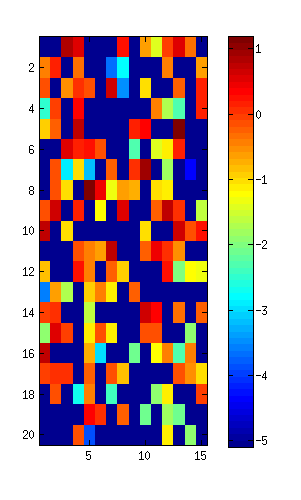 | 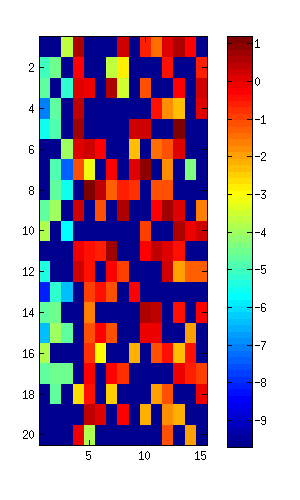
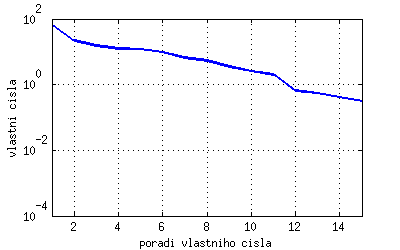 | 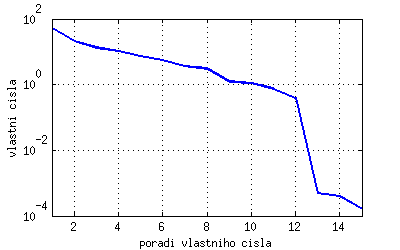

Řešením nejmenšími čtverci na špatně podmíněných datech dostáváme

<img src="img_ot/l4_ols_illcond.png">

Problém je v tom, že velká změna v odhadu $\widehat{\beta}_{OLS}$ na prvních 3 místech má minimální vliv na zpětnou rekonstrukci měření.

<img src="img_ot/l4_ols_reconstruction.png">

## Regularizace

Regularizace obecně brání přefitování problému tím, že do problému přidáme dodatečnou informaci (např. ve formě penalizace, předpokladu o nějaké hodnotě, atd.). 
$$
\min_{podminka} ||(\mathbf{y} - X\beta)^T(\mathbf{y} - X\beta)|| + g(\beta)
$$
Samozřejmě si musíme být vědomi toho, že přidáním regularizace do úlohy zásadně měníme a ovlivňujeme řešení. Typicky si přejeme např.:
- řídké řešení
- hladké řešení
- pozitivní řešení
My se nejprve podíváme na klasické metody pohledem optimalizace a následně pohledem bayesovským.

## Optimalizace

Problém lineární regrese můžeme formulovat jako optimalizační problém následovně
$$
\widehat{\beta}=\arg\min_{\beta}||X\beta-\mathbf{y}||_2^2,
$$
kde $||.||_2$ je Eukleidovská norma. Potom je to ekvivalentní s nejmenšími čtverci, neboť $||\mathbf{a}||_2^2 = \sqrt{\sum a_j^2}^2 = \mathbf{a}^T\mathbf{a}$ a vede na identické řešení.

<img src="img_ot/l4_optim.png">

## Optimalizace s Tichonovovou regularizací

Též lze najít pod názvem "ridge regression". Obecně můžeme zapsat optimalizační problém s Tichonovovským členem jako 
$$
\widehat{\beta}_{Tichonov}=\arg\min_{\beta}||\mathbf{y}-X\beta||_{2}^{2}+||\Gamma\beta||_{2}^{2},
$$
pro nějakou vhodnou matici $\Gamma$. V reálu se často setkáme s nejjednodušší volbou a to $\Gamma=\alpha I$ ($I$ značí jednotkovou matici příslušného rozměru), což má smysl penalizace velikosti koeficientů $\beta_i$. V tom případě se dokonce dostáváme k možnosti analytického řešení pomocí derivace podle $\beta$
$$
\widehat{\beta}_{Tichonov}=\left(X^{T}X+\alpha^{2}I\right)^{-1}X^{T}\mathbf{y}
$$

### Úkoly
- co vyřešila tato regularizace za problém?
- jaký nový problém nám naopak vnesla do úlohy?

Řešení na špatně podmíněných datech:
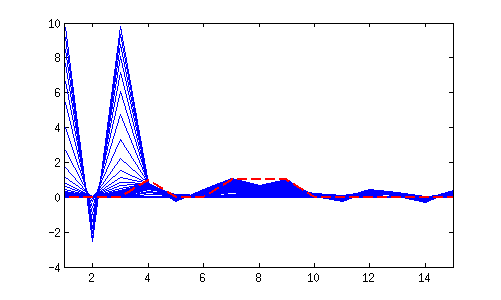<img src="img_ot/l4_tichonov_all.png">
...pro $\alpha \in 10^{-3}..10^{+3}$

<img src="img_ot/l4_tichonov1e-2.png"> | <img src="img_ot/l4_tichonov1e-0.png"> | <img src="img_ot/l4_tichonov1ep2.png">
- | - | -
<p align="center">$\alpha = 10^{-2}$ | <p align="center">$\alpha = 10^0$ | <p align="center">$\alpha = 10^2$
    
K hledání ideální hodnoty $\alpha$ můžeme použít heuristiku:
- L křivka
- cross-validace
- kouknu a vidím :-)

Použití L křivky vypadá následovně:

<img src="img_ot/l4_tichonov_Lkrivka.png"> <img src="img_ot/l4_tichonov.png">

## Optimalizace s LASSO regularizací

LASSO = least absolute shrinkage and selection operator. Jedná se o regularizaci absolutní hodnoty $\beta_i$, což vysvětluje i slovo "selection" v názvu. Nulová absolutní hodnota značí zamítnutí $\beta_i$, tzn. $\beta_i = 0$, nenulová hodnota naopak přijetí $\beta_i$. Preference nulových hodnot $\beta$ vede na řídká řešení úlohy, což má velký aplikační význam.

Předchůdce regularizace pomocí LASSO byla "stepwise regression", kde se v každém kroku algoritmu zvažovalo přijmutí/vyhození nějaké podmnožiny $\beta_1,\dots,\beta_n$, např. na základě statistických testů nebo vhodných kritérií. 

Zápis optimalizačního problému je následující
$$
\widehat{\beta}_{LASSO}=\arg\min_{\beta}||\mathbf{y}-X\beta||_{2}^{2}+\alpha||\beta||_{1},
$$
kde $||\mathbf{a}||_{1} = \sum|a_j|$.

My si opět ukážeme řešení pro rozsah parametru $\alpha \in 10^{-3}..10^{+3}$
<img src="img_ot/l4_lasso_all.png">

K hledání hodnoty $\alpha$ si opět vezmeme L křivku
<img src="img_ot/l4_lasso_Lkrivka.png">

A dostáváme řešení:

<p align="center"> LASSO | <p align="center"> Tichonov
- | -
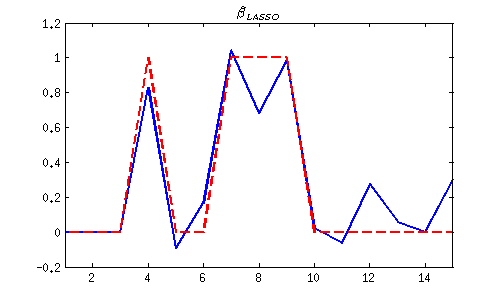 | 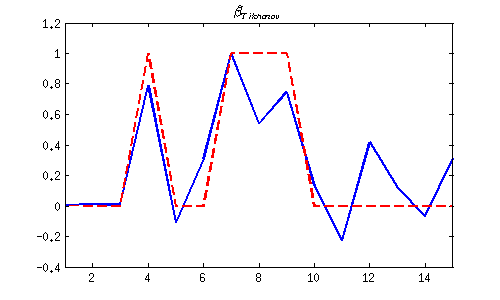
    
### Úkoly
- jakým způsobem můžeme "favorizovat" hladkost?

<img src="img_ot/l4_smooth.png">

## Optimalizace: další možnosti

Nic nám nebrání konstruovat složitější optimalizační problémy, hlavní limitací je ovšem schopnost jejich řešení. Doposud jsme konstruovali problémy konvexní (graf leží nad/pod tečnou), kde optimalizovat je poměrně snadné. Existují řešiče, zde byl použit CVX toolbox do Matlabu. Nekonvexní optimalizace je mimo rozsah tohoto předmětu.

Z dalších (konvexních) možností stojí za zmínku "elastic net" s problémem formulovaným jako
$$
\widehat{\beta}=\arg\min_{\beta}||\mathbf{y}-X\beta||_{2}^{2}+\alpha_{1}||\beta||_{2}^{2}+\alpha_{2}||\beta||_{1},
$$
ovšem za cenu 2 ladících parametrů.